In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd

In [2]:
files = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/storm_reports/StormEvents_details-ftp_v1.0_d*.csv'))

In [3]:
# Import a single ERA5 file so that we have a lat/lon grid for reference
era5_data = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')

In [4]:
# Subset a CONUS box
era5_data_conus = era5_data['CAPE'].sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [5]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [6]:
# Standardize nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [7]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1980-2024
pdo_1980_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
nino_34_1980_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1980, 2025, 1)))

# only MAM
pdo_1980_2024_mam = pdo_1980_2024.sel(time=pdo_1980_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1980_2024_mam = nino_34_1980_2024.sel(time=nino_34_1980_2024.time.dt.month.isin([3, 4, 5]))

In [8]:
# Read and concatenate in order
storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

/tmp/ipykernel_15561/3445745825.py:2: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_15561/3445745825.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_15561/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_15561/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_15561/3445745825.py:2: DtypeWarning: Columns (29,34,35,37) have mixed types. Sp

In [9]:
storm_reports['BEGIN_YEARMONTH'] = pd.to_datetime(storm_reports['BEGIN_YEARMONTH'], format='%Y%m')
storm_reports['END_YEARMONTH'] = pd.to_datetime(storm_reports['END_YEARMONTH'], format='%Y%m')

In [10]:
# Extract the month
storm_reports["MONTH"] = storm_reports["BEGIN_YEARMONTH"].dt.month

In [11]:
# Specify different storm types
tornados = storm_reports[storm_reports['EVENT_TYPE'].isin(['Tornado'])]
hail = storm_reports[storm_reports['EVENT_TYPE'].isin(['Hail'])]
tstorm_wind = storm_reports[storm_reports['EVENT_TYPE'].isin(['Thunderstorm Wind'])]

In [12]:
# Subset storm reports by time periods
tornados_mam = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tornados_mar = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3])]
tornados_apr = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([4])]
tornados_may = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([5])]

hail_mam = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
hail_mar = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3])]
hail_apr = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([4])]
hail_may = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([5])]

tstorm_wind_mam = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tstorm_wind_mar = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3])]
tstorm_wind_apr = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([4])]
tstorm_wind_may = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([5])]

In [13]:
# Want to mess around with grid size a little bit to see if we can get a more coherent signal
lat_edges = np.append(era5_data_conus['latitude'].values-0.25, 23.5)
lon_edges = np.append(era5_data_conus['longitude'].values-0.25, 294)

lat_edges_0_5deg = lat_edges[::2]
lon_edges_0_5deg = lon_edges[::2]

In [14]:
tornado_counts_mam_separated = np.zeros((135, 50, 118))
for i in range(45):
    tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [15]:
hail_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    hail_yr_mar = hail_mar.loc[hail_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_apr = hail_apr.loc[hail_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    hail_yr_may = hail_may.loc[hail_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(hail_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(hail_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    hail_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(hail_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [16]:
tstorm_wind_counts_mam_separated = np.zeros((135, 50, 118))

for i in range(45):
    tstorm_wind_yr_mar = tstorm_wind_mar.loc[tstorm_wind_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_apr = tstorm_wind_apr.loc[tstorm_wind_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    tstorm_wind_yr_may = tstorm_wind_may.loc[tstorm_wind_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tstorm_wind_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tstorm_wind_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    tstorm_wind_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tstorm_wind_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [17]:
# Lets try regressing the PDO onto storm reports
tornado_corr_pdo, tornado_regress_pdo       = pdo_functions.linregress_3D(pdo_1980_2024_mam.values, tornado_counts_mam_separated)[1:3]
tornado_corr_nino, tornado_regress_nino     = pdo_functions.linregress_3D(nino_34_1980_2024_mam.values, tornado_counts_mam_separated)[1:3]

tstorm_wind_corr_pdo, tstorm_wind_regress_pdo   = pdo_functions.linregress_3D(pdo_1980_2024_mam.values, tstorm_wind_counts_mam_separated)[1:3]
tstorm_wind_corr_nino, tstorm_wind_regress_nino = pdo_functions.linregress_3D(nino_34_1980_2024_mam.values, tstorm_wind_counts_mam_separated)[1:3]

hail_corr_pdo, hail_regress_pdo          = pdo_functions.linregress_3D(pdo_1980_2024_mam.values, hail_counts_mam_separated)[1:3]
hail_corr_nino, hail_regress_nino        = pdo_functions.linregress_3D(nino_34_1980_2024_mam.values, hail_counts_mam_separated)[1:3]

In [18]:
# Calculate t-statistics from correlation
tornado_t_stat_pdo  = tornado_corr_pdo * ((135-2)**0.5) / ((1-tornado_corr_pdo ** 2) ** 0.5)
tornado_t_stat_nino = tornado_corr_nino * ((135-2)**0.5) / ((1-tornado_corr_nino ** 2) ** 0.5)

tstorm_wind_t_stat_pdo  = tstorm_wind_corr_pdo * ((135-2)**0.5) / ((1-tstorm_wind_corr_pdo ** 2) ** 0.5)
tstorm_wind_t_stat_nino = tstorm_wind_corr_nino * ((135-2)**0.5) / ((1-tstorm_wind_corr_nino ** 2) ** 0.5)

hail_t_stat_pdo  = hail_corr_pdo * ((135-2)**0.5) / ((1-hail_corr_pdo ** 2) ** 0.5)
hail_t_stat_nino = hail_corr_nino * ((135-2)**0.5) / ((1-hail_corr_nino ** 2) ** 0.5)

In [19]:
# Calculate p-values from t-statistics
tornado_p_val_pdo  = 2 * (1 - scipy.stats.t.cdf(abs(tornado_t_stat_pdo), 135-2))
tornado_p_val_nino = 2 * (1 -scipy.stats.t.cdf(abs(tornado_t_stat_nino), 132-2))

tstorm_wind_p_val_pdo  = 2 * (1 - scipy.stats.t.cdf(abs(tstorm_wind_t_stat_pdo), 135-2))
tstorm_wind_p_val_nino = 2 * (1 - scipy.stats.t.cdf(abs(tstorm_wind_t_stat_nino), 132-2))

hail_p_val_pdo  = 2 * (1 - scipy.stats.t.cdf(abs(hail_t_stat_pdo), 135-2))
hail_p_val_nino = 2 * (1 - scipy.stats.t.cdf(abs(hail_t_stat_nino), 132-2))

In [20]:
# Adjusted p-values
tornado_adj_p_pdo =  pdo_functions.control_FDR(tornado_p_val_pdo, 50, 118)
tornado_adj_p_nino = pdo_functions.control_FDR(tornado_p_val_nino, 50, 118)

tstorm_wind_adj_p_pdo =  pdo_functions.control_FDR(tstorm_wind_p_val_pdo, 50, 118)
tstorm_wind_adj_p_nino = pdo_functions.control_FDR(tstorm_wind_p_val_nino, 50, 118)

hail_adj_p_pdo =  pdo_functions.control_FDR(hail_p_val_pdo, 50, 118)
hail_adj_p_nino = pdo_functions.control_FDR(hail_p_val_nino, 50, 118)

In [21]:
# Making significance arrays for plotting
tornado_sig_pdo  = np.where(tornado_p_val_pdo < tornado_adj_p_pdo, 3, 0)
tornado_sig_nino = np.where(tornado_p_val_nino < tornado_adj_p_nino, 3, 0)

tstorm_wind_sig_pdo  = np.where(tstorm_wind_p_val_pdo < tstorm_wind_adj_p_pdo, 3, 0)
tstorm_wind_sig_nino = np.where(tstorm_wind_p_val_nino < tstorm_wind_adj_p_nino, 3, 0)

hail_sig_pdo  = np.where(hail_p_val_pdo < hail_adj_p_pdo, 3, 0)
hail_sig_nino = np.where(hail_p_val_nino < hail_adj_p_nino, 3, 0)

In [22]:
tornado_regress_pdo[tornado_regress_pdo == 0]           = np.nan
tornado_regress_nino[tornado_regress_nino == 0]         = np.nan

tstorm_wind_regress_pdo[tstorm_wind_regress_pdo == 0]   = np.nan
tstorm_wind_regress_nino[tstorm_wind_regress_nino == 0] = np.nan

hail_regress_pdo[hail_regress_pdo == 0]                 = np.nan
hail_regress_nino[hail_regress_nino == 0]               = np.nan

In [24]:
tstorm_wind_sig_pdo

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

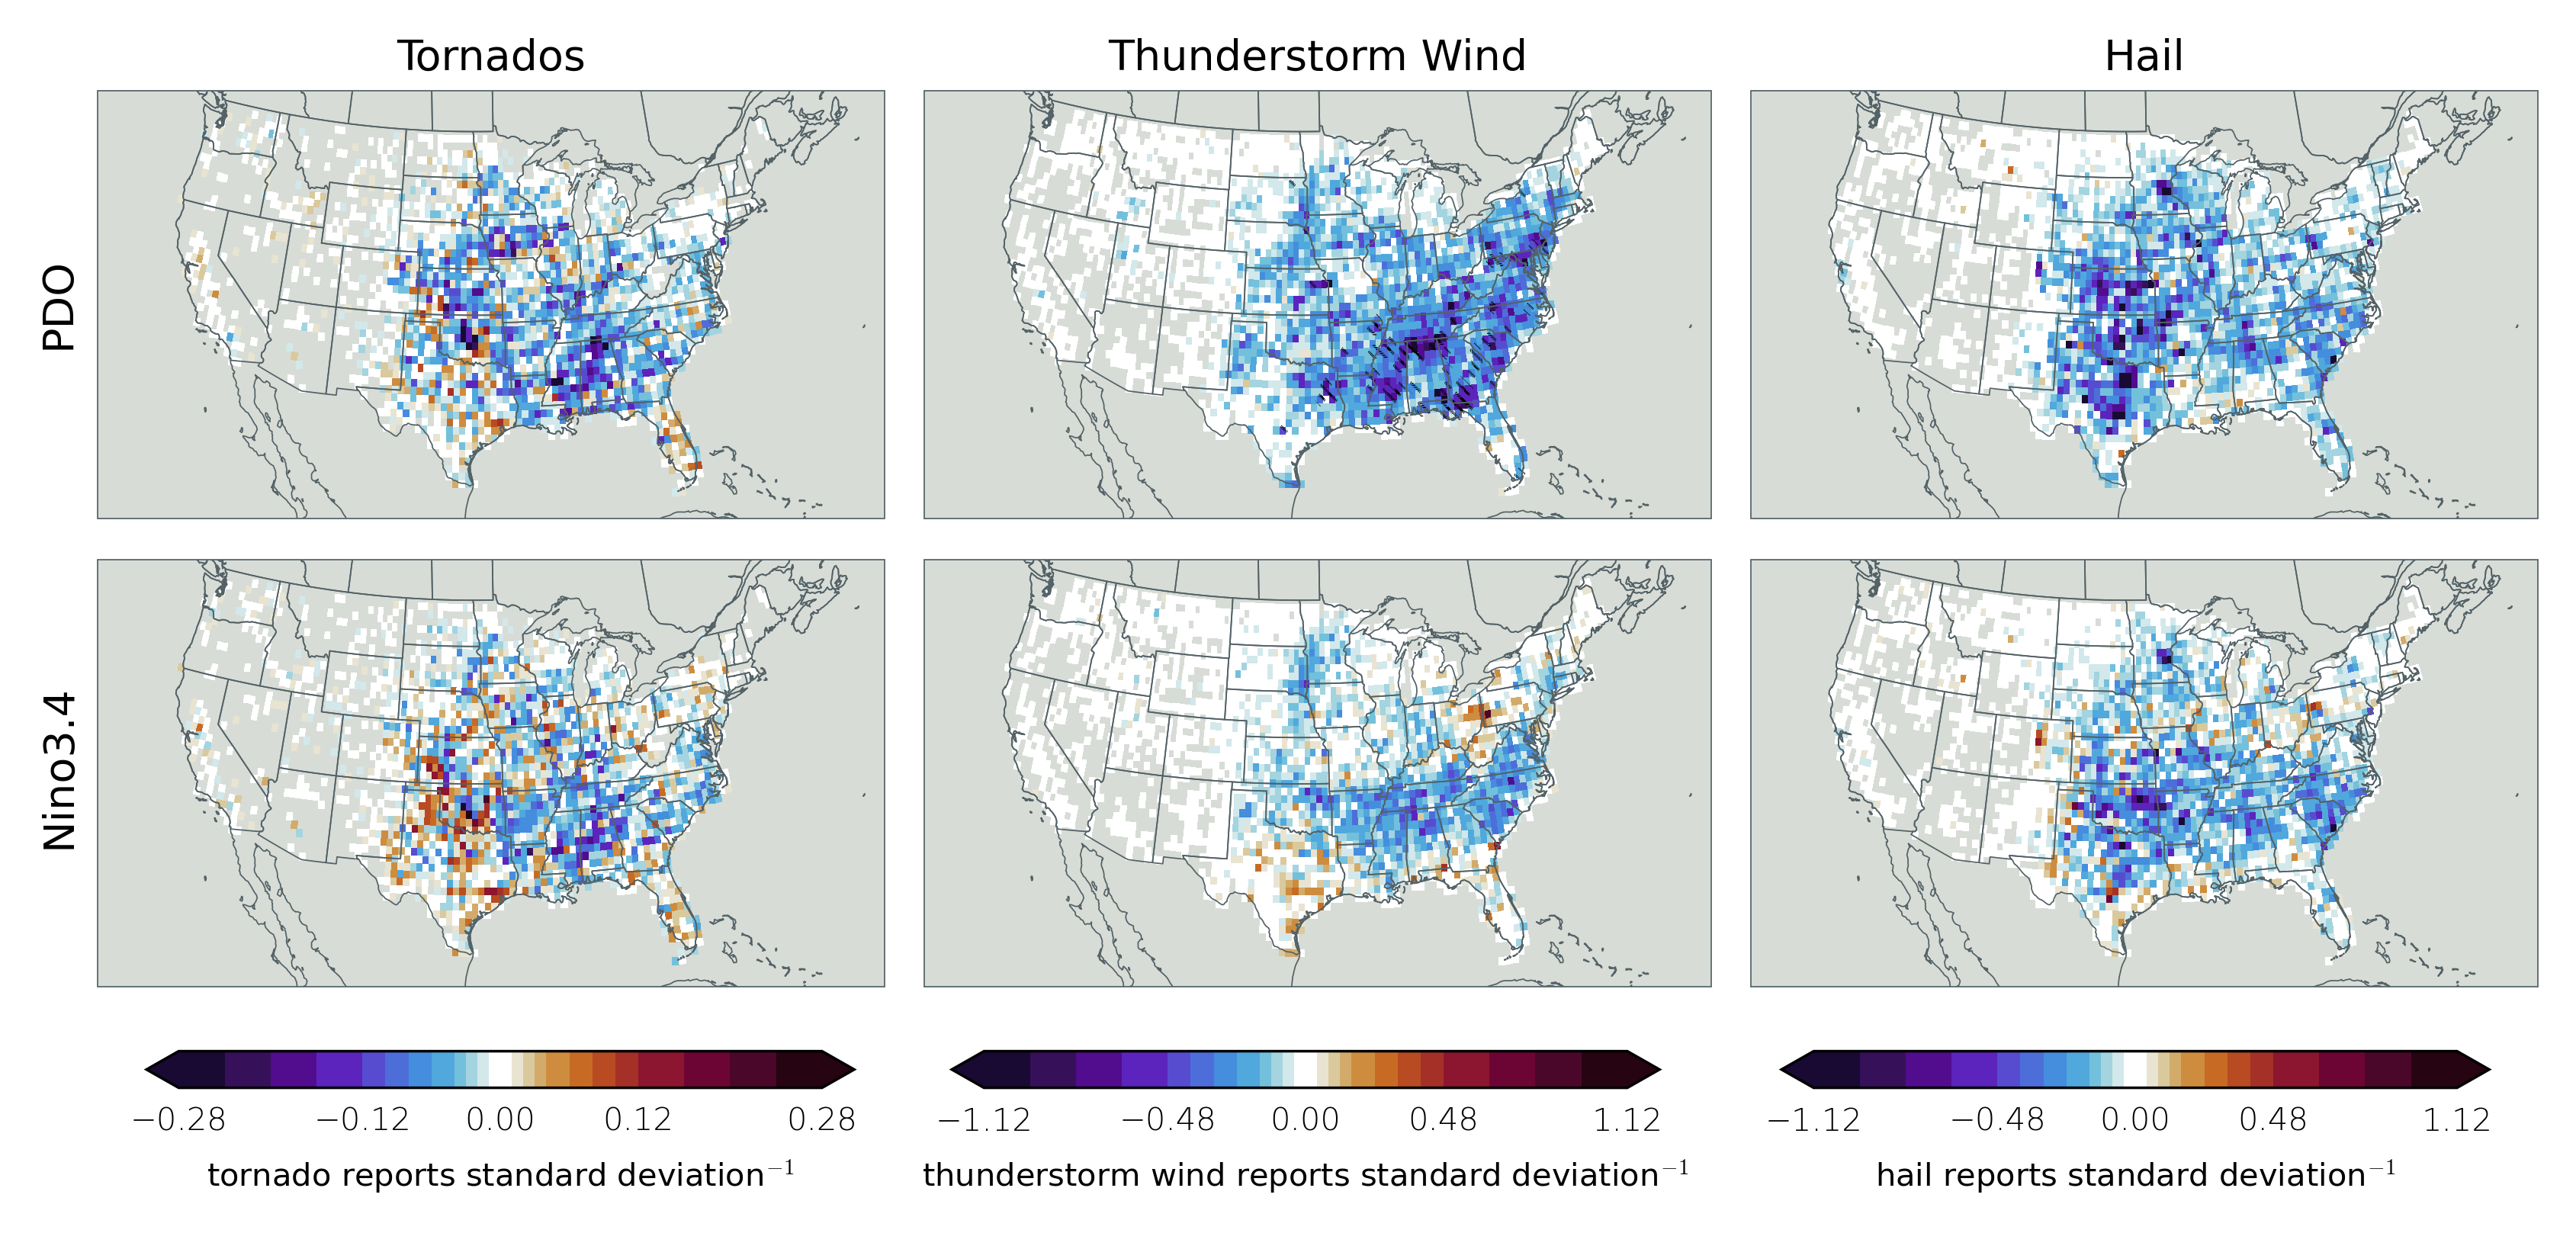

In [23]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

tornado_bounds = [-0.28, -0.24, -0.2, -0.16, -0.12, -0.1, -0.08, -0.06, -0.04, -0.03, -0.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.12, 0.16, 0.2, 0.24, 0.28]
tornado_norm   = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

tstorm_wind_bounds = [-1.12, -0.96, -0.8, -0.64, -0.48, -0.4, -0.32, -0.24, -0.16, -0.12, -0.08, -0.04, 0.04, 0.08, 0.12, 0.16, 0.24, 0.32, 0.4, 0.48, 0.64, 0.8, 0.96, 1.12]
tstorm_wind_norm   = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

hail_bounds = [-1.12, -0.96, -0.8, -0.64, -0.48, -0.4, -0.32, -0.24, -0.16, -0.12, -0.08, -0.04, 0.04, 0.08, 0.12, 0.16, 0.24, 0.32, 0.4, 0.48, 0.64, 0.8, 0.96, 1.12]
hail_norm   = c.BoundaryNorm(hail_bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_regress_pdo), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=tornado_norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tornado_regress_nino), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=tornado_norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_regress_pdo), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(tstorm_wind_regress_nino), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_regress_pdo), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=hail_norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(hail_regress_nino), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=hail_norm)

if len(lon_edges_0_5deg) == tornado_sig_pdo.shape[1] + 1:
    lon_centers_0_5deg = 0.5 * (lon_edges_0_5deg[:-1] + lon_edges_0_5deg[1:])
if len(lat_edges_0_5deg) == tornado_sig_pdo.shape[0] + 1:
    lat_centers_0_5deg = 0.5 * (lat_edges_0_5deg[:-1] + lat_edges_0_5deg[1:])

ax[0].contourf(lon_centers_0_5deg, lat_centers_0_5deg, np.flipud(tornado_sig_pdo), transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)
ax[1].contourf(lon_centers_0_5deg, lat_centers_0_5deg, np.flipud(tstorm_wind_sig_pdo), transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)
ax[2].contourf(lon_centers_0_5deg, lat_centers_0_5deg, np.flipud(hail_sig_pdo), transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)

cax = plt.axes([0.02, .2, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tornado_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.28, -0.12, 0, 0.12, 0.28])
cbar.set_label(r'tornado reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.35, .2, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-1.12, -0.48, 0, 0.48, 1.12])
cbar2.set_label(r'thunderstorm wind reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.69, .2, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=hail_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', ticks=[-1.12, -0.48, 0, 0.48, 1.12])
cbar3.set_label(r'hail reports standard deviation$^{-1}$', size=6, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=6, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('Tornados', fontsize=8, pad=4)
ax[1].set_title('Thunderstorm Wind', fontsize=8, pad=4)
ax[2].set_title('Hail', fontsize=8, pad=4)

ax[0].text(-3250000, -120000, 'PDO', rotation='vertical', fontweight='normal', fontsize=8)
ax[3].text(-3250000, -350000, 'Nino3.4', rotation='vertical', fontweight='normal', fontsize=8)

plt.rcParams.update({'hatch.color': 'xkcd:pink'})

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)